In [2]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
from sklearn.metrics import auc, roc_curve, classification_report
from scipy import stats

#import h2o
#from h2o.frame import H2OFrame
#from h2o.estimators.random_forest import H2ORandomForestEstimator
#from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline
sns.set(style="white",context="talk")

## Goal
1. What percentage of users opened the email and what percentage clicked on the link within the email?
2. **Which segment of users have the most success rate** build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email? 
3. **ABT Experiment design** By how much do you think your model would improve click through rate ( defined as # of users who click on the link / total users who received the email). How would you test that?

# Question 3
Based on the model built previously, the company can send email to selected users that are predicted to have higher probability to click the link. 

To test it, we can conduct A/B test to see if the built model can actually help improve the click-through-rate.
* Randomly assign users to two groups, Control group and Experiment group.
* In Control group, still use the old email-campaign strategy, i.e., just send emails to all users in Control group.
* In Experiment group, use my model to predict whether the user will click the link or not. and only send emails to those users whose predictive result is positive.
* Preform a one-tail unpaired t-test to test whether Experiement group's population proportion is higher than Control group's population proportion.

# 1. Loading and Processing the data

In [4]:
# Load the conversion project dataset
email = pd.read_csv("email_table.csv", sep = ",")
email_open = pd.read_csv("email_opened_table.csv", sep = ",")
link_clk = pd.read_csv("link_clicked_table.csv", sep = ",")

In [6]:
print(f'email info table consists of {email.shape[0]} rows and {email.shape[1]} cols')
print(f'email open table consists of {email_open.shape[0]} rows and {email_open.shape[1]} cols')
print(f'link clicked table consists of {link_clk.shape[0]} rows and {link_clk.shape[1]} cols')

email info table consists of 100000 rows and 7 cols
email open table consists of 10345 rows and 1 cols
link clicked table consists of 2119 rows and 1 cols


In [27]:
def data_preview(df):
    # Exploring the data types, number of unique values and missing values
    cols = df.columns
    print(f"The dataset consists of {df.shape[0]} rows and {df.shape[1]} columns")
    print(f"The columns are: {df.columns.tolist()}")
    return pd.concat([pd.DataFrame({"data_types":df.dtypes, 
              "value_counts": df.nunique(),
             "null_counts": df.isnull().sum()}).T,df.iloc[0:3,:]],axis = 0)


In [29]:
data_preview(email)

The dataset consists of 100000 rows and 7 columns
The columns are: ['email_id', 'email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
data_types,int64,object,object,int64,object,object,int64
value_counts,100000,2,2,24,7,4,23
null_counts,0,0,0,0,0,0,0
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2


In [30]:
data_preview(email_open)

The dataset consists of 10345 rows and 1 columns
The columns are: ['email_id']


,email_id
data_types,int64
value_counts,10345
null_counts,0
0,284534
1,609056
2,220820


In [31]:
data_preview(link_clk)

The dataset consists of 2119 rows and 1 columns
The columns are: ['email_id']


,email_id
data_types,int64
value_counts,2119
null_counts,0
0,609056
1,870980
2,935124


### Preparing labels

In [40]:
email_open["open"] = 1
link_clk["click"] = 1

### Sanity check
All the people who clicks also open the email => correct

In [52]:
open_clk = pd.merge(left = email_open, right = link_clk, how = "left", on = "email_id").fillna(0)
open_clk[open_clk.click == 1].open.value_counts()

1    2069
Name: open, dtype: int64

### Merge the three dataset together

In [62]:
data = pd.merge(left = email, right = open_clk, how = "left", on = "email_id").fillna(0)
data_preview(data)

The dataset consists of 100000 rows and 9 columns
The columns are: ['email_id', 'email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases', 'open', 'click']


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,open,click
data_types,int64,object,object,int64,object,object,int64,float64,float64
value_counts,100000,2,2,24,7,4,23,2,2
null_counts,0,0,0,0,0,0,0,0,0
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0


### Descriptive Stats: 
- average open percentage is 10.3%, 
- average click rate of the population is 2%
- average click rate among the people who open the email is 20%

In [63]:
data[["open","click"]].mean()

open     0.10345
click    0.02069
dtype: float64

In [64]:
data[data.open == 1].click.mean()

0.2

# 2. EDA

### 2-1. Hour
1. Come up with ways to improve open date at 23pm
2. Come up with ways to improve click rate at 24pm

In [65]:
data["hour_str"] = data["hour"].astype(str)

In [92]:
def email_plot(cat_col,num_feat):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    sns.countplot(x= cat_col, data=data.sort_values(by =  cat_col),ax=axes[0],palette=sns.color_palette("viridis",num_feat))
    axes[0].set_title(f'Count Plot per {cat_col}', fontsize=14)
    axes[0].grid(linestyle="--", alpha=0.2)
    axes[0].set_ylabel("# of Email Sent")

    sns.barplot(x= cat_col, y='open', data=data.sort_values(by =  cat_col), ci=0, ax=axes[1],palette=sns.color_palette("viridis",num_feat));
    axes[1].set_title(f'Mean Email Open Rate per {cat_col}(Among Population)', fontsize=14)
    axes[1].grid(linestyle="--", alpha=0.2)
    axes[1].set_ylabel("% Email Open Rate")

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    sns.barplot(x= cat_col, y='click', data=data.sort_values(by =  cat_col), ci=0, ax=axes[0],palette=sns.color_palette("viridis",num_feat));
    axes[0].set_title(f'Mean Email click Rate per {cat_col} (Among Population)', fontsize=14)
    axes[0].grid(linestyle="--", alpha=0.2)
    axes[0].set_ylabel("% Email click Rate")

    sns.barplot(x= cat_col, y='click', data=data[data.open == 1].sort_values(by =  cat_col), ci=0, ax=axes[1],palette=sns.color_palette("viridis",num_feat));
    axes[1].set_title(f'Mean Email click Rate per {cat_col}(Among opened people)', fontsize=14)
    axes[1].grid(linestyle="--", alpha=0.2)
    axes[1].set_ylabel("% Email click Rate")

    plt.show()

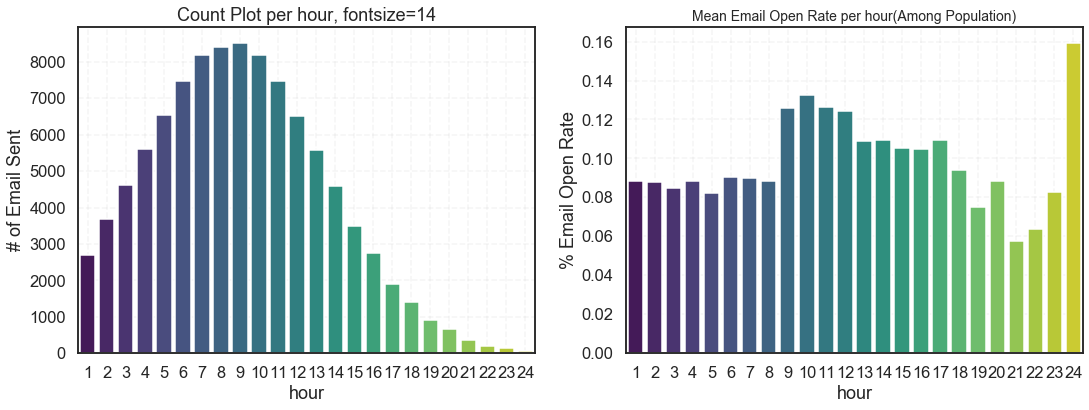

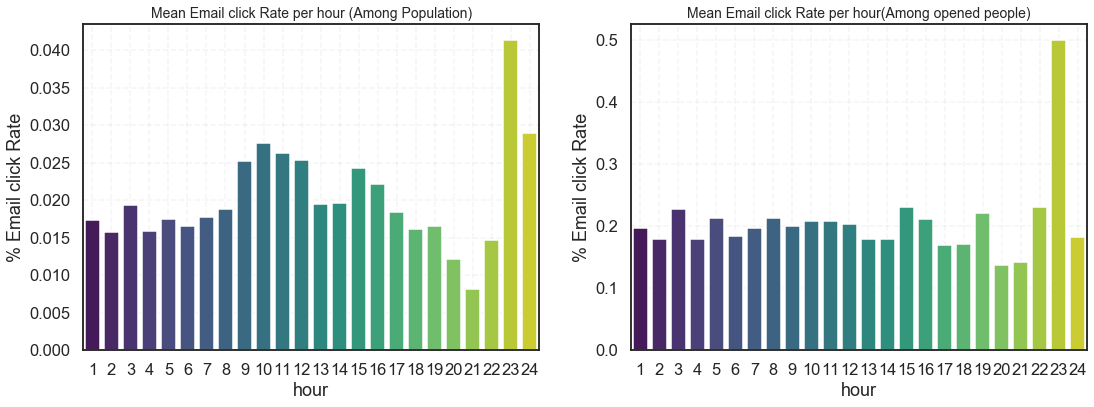

In [90]:
email_plot("hour",24)

In [82]:
    def get_hourday(x):
        if 0<= x < 6:
            return "midnight"
        elif 6<= x < 12:
            return "morning"
        elif 12<= x < 18:
            return "afternoon"
        else:
            return "night"
data["hourday"] = list(map(lambda x: get_hourday(x), data["hour"]))

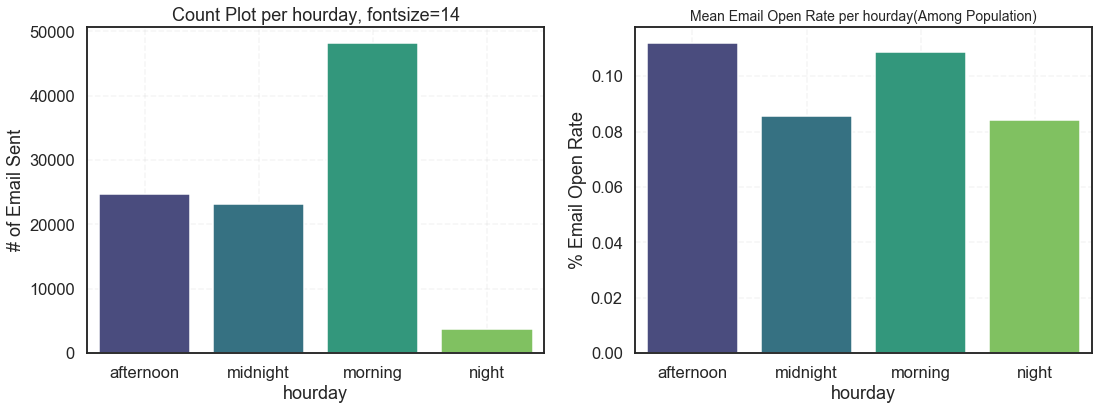

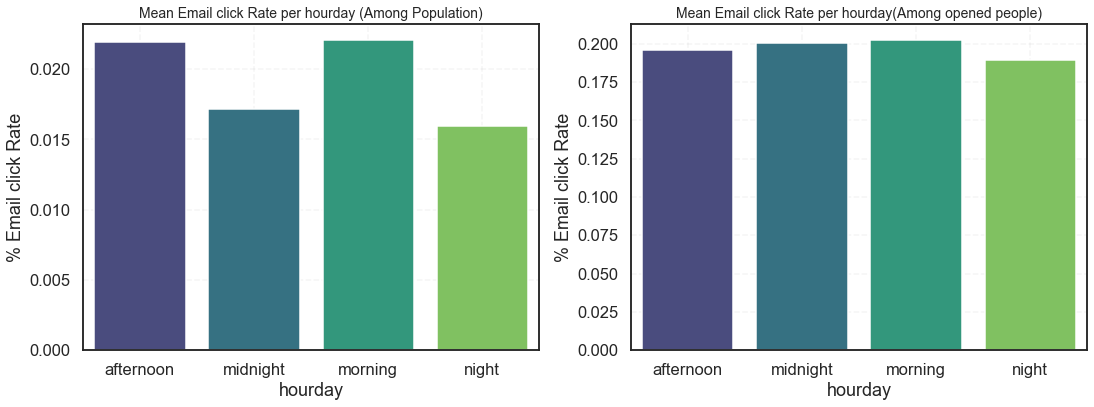

In [91]:
email_plot("hourday",4)

### Text length
Short_email better

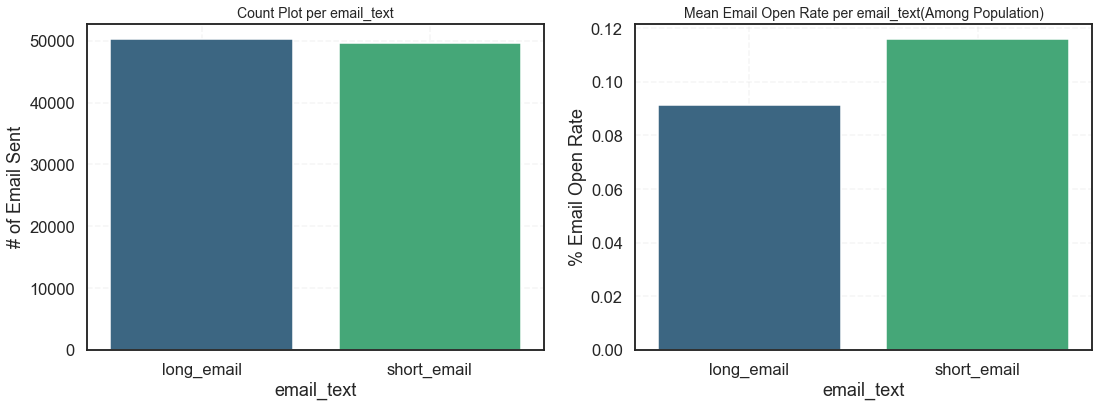

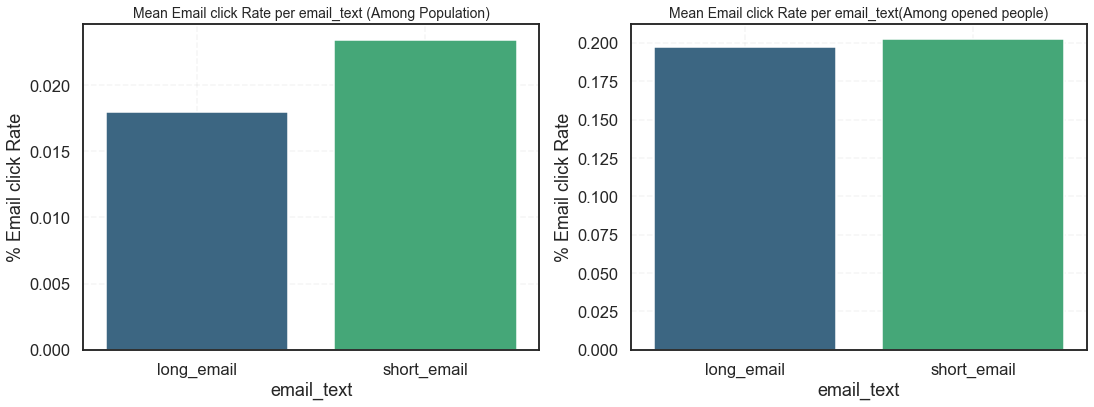

In [104]:
email_plot("email_text",2)

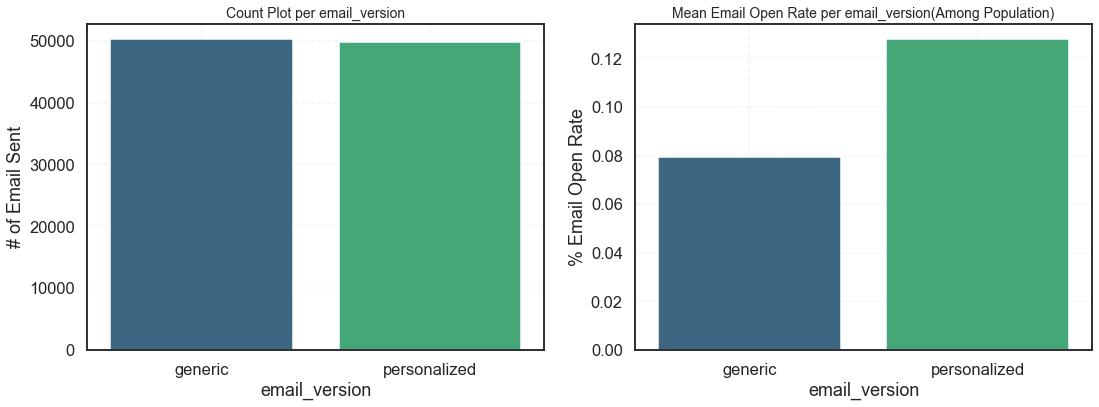

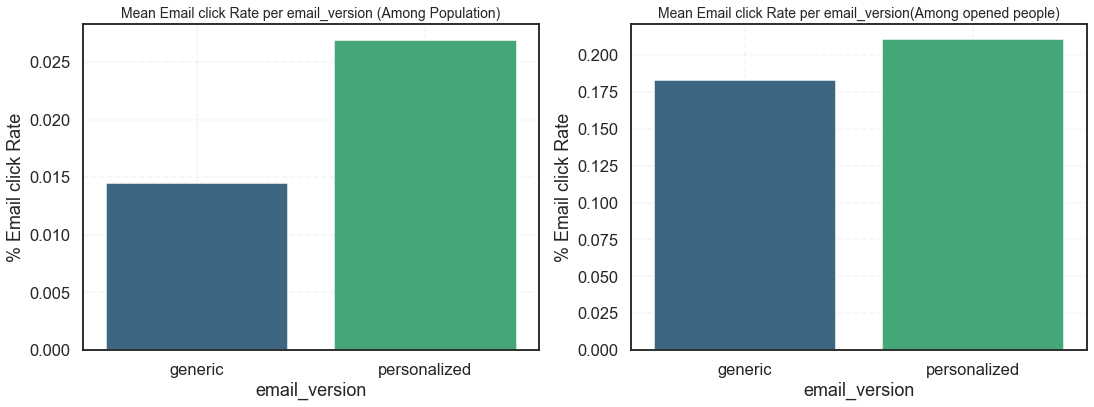

In [105]:
email_plot("email_version",2)

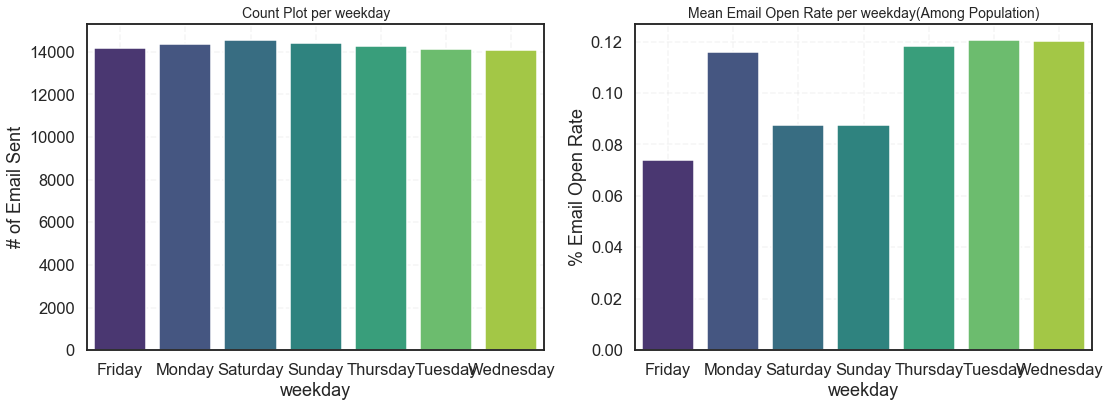

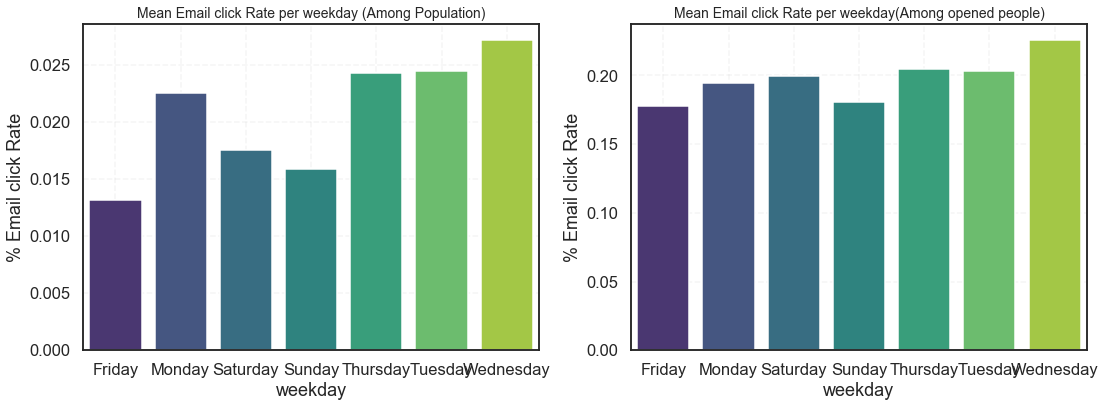

In [106]:
email_plot("weekday",7)

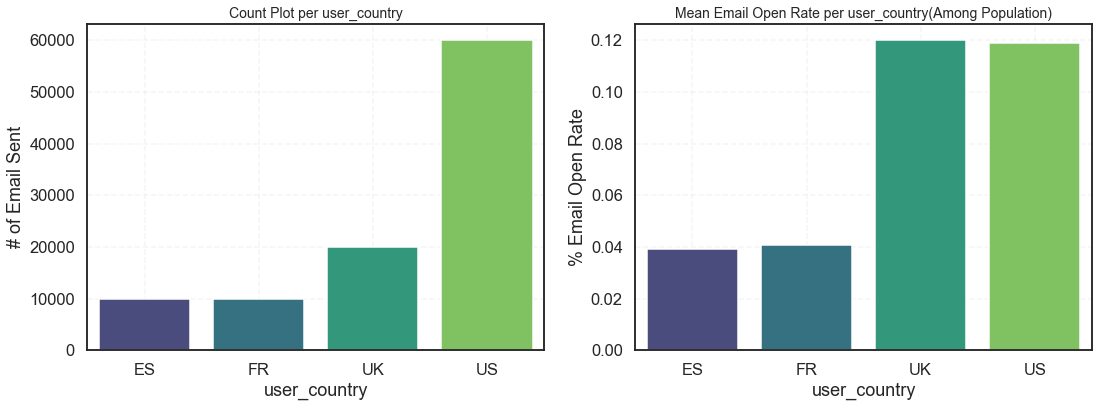

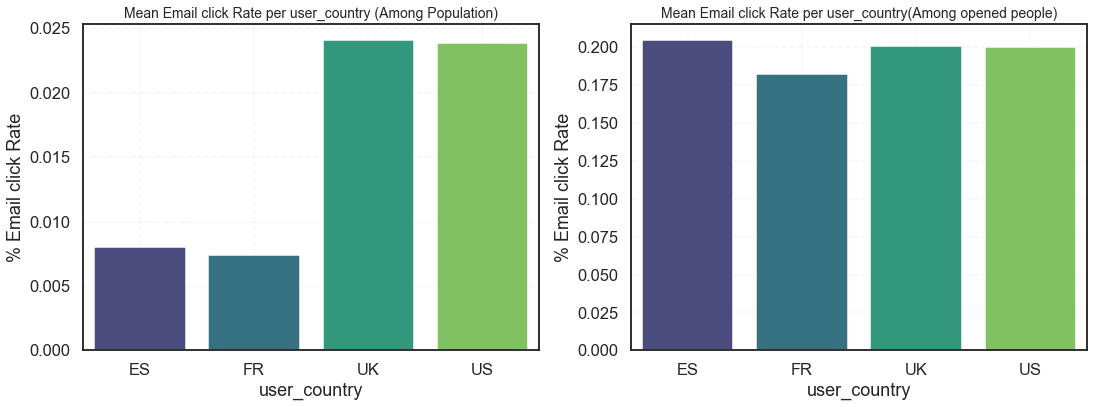

In [107]:
email_plot("user_country",4)

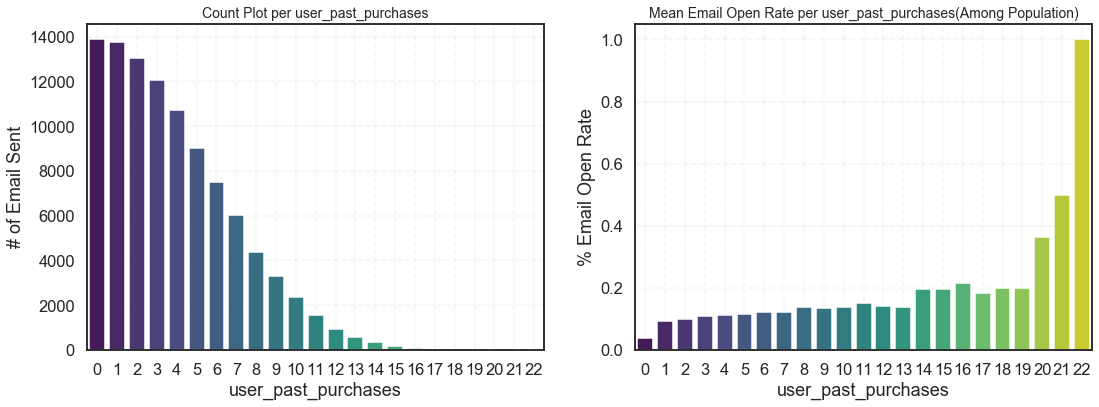

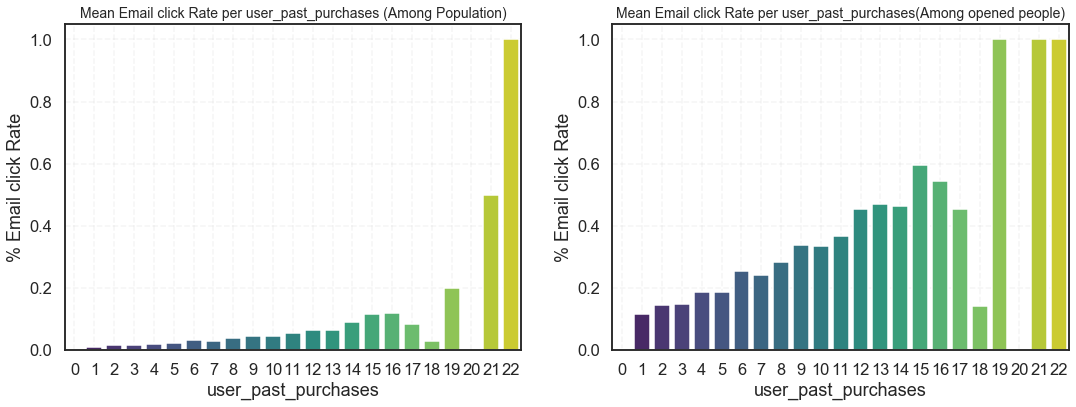

In [111]:
email_plot("user_past_purchases",23)

# Modeling

In [162]:
# Undersample to recreate a balanced training set
def undersample(data, target_col):
    data_neg = data[data[target_col] == 0].sample(n=len(data[data[target_col] == 1]), random_state=111)
    return pd.concat([data_neg, data[data[target_col] == 1]],axis = 0)
data = undersample(data,"open")

### 1. Linear Model (OLS)

In [213]:
predictors = data.drop(["hourday","hour","email_id","open","click"],axis = 1).columns.tolist()

In [214]:
import statsmodels.api as sm

X = pd.get_dummies(data[predictors],drop_first = True)
y_open = data['open']

X2 = sm.add_constant(X)
est = sm.OLS(y_open, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                   open   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     59.11
Date:                Sat, 23 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:32:52   Log-Likelihood:                -14029.
No. Observations:               20690   AIC:                         2.813e+04
Df Residuals:                   20654   BIC:                         2.842e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [215]:
import statsmodels.api as sm

X = pd.get_dummies(data[predictors],drop_first = True)
y_clk = data['click']

X2 = sm.add_constant(X)
est = sm.OLS(y_open, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                   open   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     59.11
Date:                Sat, 23 Jan 2021   Prob (F-statistic):               0.00
Time:                        18:32:52   Log-Likelihood:                -14029.
No. Observations:               20690   AIC:                         2.813e+04
Df Residuals:                   20654   BIC:                         2.842e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### 2. RF

#### Open

In [216]:
# hold out 20% as validation dataset for evaluation purpose
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X, y_open, test_size=0.2, random_state=42)

In [217]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

rf_clf = RandomForestClassifier(oob_score = True, max_features='auto' ,random_state=10)
rf_parameters = {"n_estimators":[50,80,100], "max_depth":[3,5,7], "min_samples_split" :[2,5,8], "min_samples_leaf":[2,5,8]}
rf_random_search = RandomizedSearchCV(rf_clf, rf_parameters, n_jobs = -1, cv = 5, scoring = "roc_auc", n_iter = 20)
rf_random_search.fit(x_train, y_train.values.ravel())

print(rf_random_search.best_params_)
rf_clf_best = rf_random_search.best_estimator_
print(rf_clf_best.score(x_train, y_train))

{'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_depth': 7}
0.6348477525374577


In [218]:
fea_imp = pd.DataFrame({"importance":[round(x,4) for x in rf_clf_best.feature_importances_],
                        "feature":x_train.columns.values}).sort_values(by = "importance", ascending = False)
fea_imp

,importance,feature
0,0.2982,user_past_purchases
2,0.1850,email_version_personalized
9,0.1184,user_country_FR
11,0.1127,user_country_US
10,0.0739,user_country_UK
1,0.0441,email_text_short_email
12,0.0220,hour_str_10
7,0.0128,weekday_Tuesday
8,0.0121,weekday_Wednesday
4,0.0120,weekday_Saturday


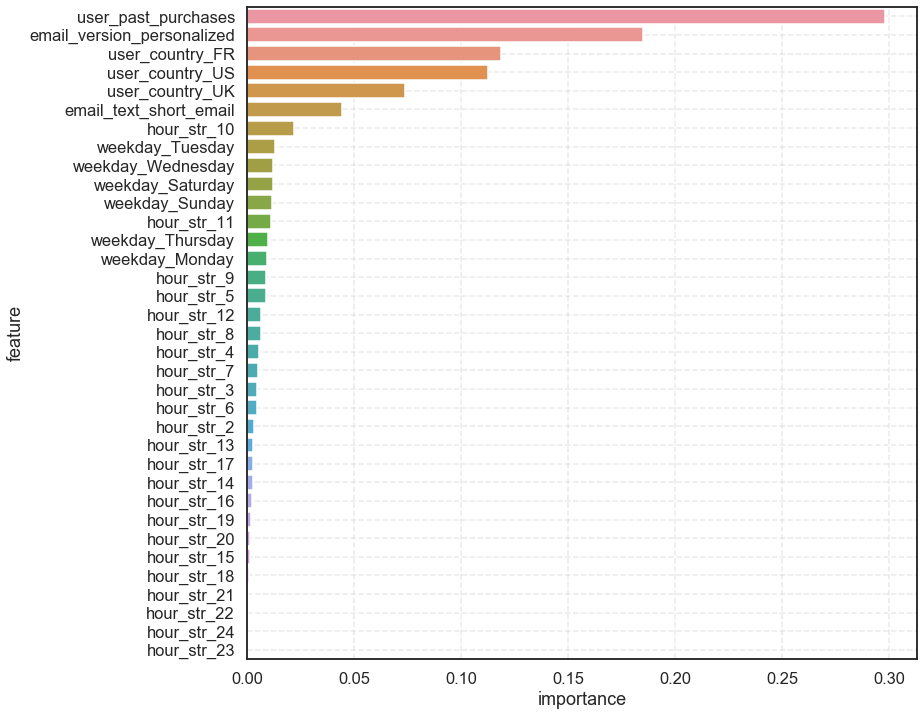

In [219]:
f = plt.figure(figsize = (12,12))
sns.barplot(x = "importance", y = "feature", data = fea_imp)
plt.grid(linestyle="--", alpha=0.4)

# 4. Evaluation

In [220]:
def get_classification_report(model, x_train, y_train, x_valid, y_valid):
    train_true = y_train
    valid_true = y_valid
    train_pred = rf_clf_best.predict_proba(x_train)[:,1]
    valid_pred = rf_clf_best.predict_proba(x_valid)[:,1]
    
    # Make predictions
    train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
    valid_fpr, valid_tpr, _ = roc_curve(valid_true, valid_pred)
    train_auc = np.round(auc(train_fpr, train_tpr), 3)
    valid_auc = np.round(auc(valid_fpr, valid_tpr), 3)

    # F1-score = 2 * precision*recall / (precision+recall)
    print(classification_report(y_true=valid_true, y_pred=(valid_pred > 0.5).astype(int),
                                target_names = ["negative:0","positive:1"]))

In [221]:
train_true = y_train
valid_true = y_valid
train_pred = rf_clf_best.predict_proba(x_train)[:,1]
valid_pred = rf_clf_best.predict_proba(x_valid)[:,1]

In [222]:
# Make predictions

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
valid_fpr, valid_tpr, _ = roc_curve(valid_true, valid_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
valid_auc = np.round(auc(valid_fpr, valid_tpr), 3)

In [223]:
# F1-score = 2 * precision*recall / (precision+recall)
print(classification_report(y_true=valid_true, y_pred=(valid_pred > 0.5).astype(int),target_names = ["not converted:0","converted:1"]))

                 precision    recall  f1-score   support

not converted:0       0.66      0.54      0.60      2105
    converted:1       0.60      0.71      0.65      2033

       accuracy                           0.62      4138
      macro avg       0.63      0.63      0.62      4138
   weighted avg       0.63      0.62      0.62      4138



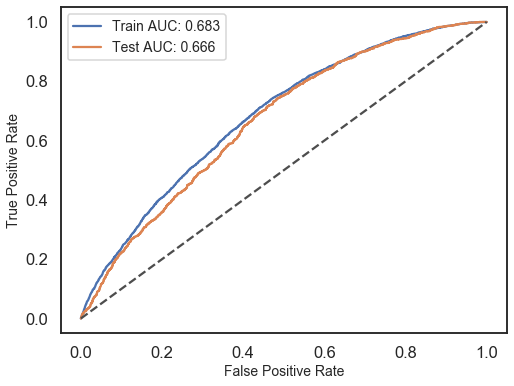

In [224]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(valid_fpr, valid_tpr, label='Test AUC: ' + str(valid_auc))
ax.plot([0, 1], [0, 1], ls="--", c=".3")
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.legend(fontsize=14)
plt.show()